_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

# Part 1 

## Required

In [2]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [3]:
df.tail(5)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2019-06-05,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,GSW,TOR,Playoffs,-13.0
2019-06-05,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,GSW,TOR,Playoffs,-14.0
2019-06-05,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,GSW,TOR,Playoffs,-17.0
2019-06-05,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,GSW,TOR,Playoffs,-16.0
2019-06-05,41800403,658,Stephen Curry,4,2,47,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24,-226,104,0,GSW,TOR,Playoffs,-12.0


In [4]:
train = df.loc['2009-10':'2017-06'];
val = df.loc['2017-10':'2018-06'];
test = df.loc['2018-10':'2019-06'];
train.shape, val.shape, test.shape

assert (train.shape[0] + val.shape[0] + test.shape[0]) == df.shape[0]

In [5]:
feature1 = ['shot_zone_range', 'action_type', 'shot_zone_basic']
target = 'shot_made_flag';

x_train = train[feature1];
y_train = train[target];

x_val = val[feature1];
y_val = val[target];

x_test = test[feature1];
y_test = test[target];

In [6]:
import category_encoders as ce;
from sklearn.pipeline import make_pipeline;
from sklearn.metrics import accuracy_score;
from sklearn.impute import SimpleImputer;
from sklearn.linear_model import LogisticRegression;
from sklearn.linear_model import LinearRegression;

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    LogisticRegression()
);

In [7]:
pipeline.fit(x_train, y_train);

/Users/ashwin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
pipeline.score(x_val, y_val)

0.6121575342465754

In [9]:
pipeline.predict(x_test)

array([1, 1, 1, ..., 1, 1, 0])

## Stretch Goals

In [10]:
df['homecourt_advantage'] = df['htm'] == 'GSW'
df['homecourt_advantage'].head()

game_date
2009-10-28    True
2009-10-28    True
2009-10-28    True
2009-10-28    True
2009-10-28    True
Name: homecourt_advantage, dtype: bool

In [11]:
df['seconds_remaining_in_period'] = df['seconds_remaining'] + df['minutes_remaining'] * 60;
df['seconds_remaining_in_period'].head()

game_date
2009-10-28    685
2009-10-28    571
2009-10-28    362
2009-10-28    589
2009-10-28    139
Name: seconds_remaining_in_period, dtype: int64

In [12]:
df['seconds_remaining_in_game'] = df['seconds_remaining_in_period'] + 12 * (4 - df['period'])
df['seconds_remaining_in_game'].head()

game_date
2009-10-28    721
2009-10-28    607
2009-10-28    398
2009-10-28    613
2009-10-28    163
Name: seconds_remaining_in_game, dtype: int64

In [13]:
import numpy as np;
shot_made = df['shot_made_flag'].tolist();
print(len(shot_made))
shot_made.pop(len(shot_made)-1)
shot_made.insert(0, 0)
print(len(shot_made))

13958
13958


In [14]:
df['made_previous_shot'] = shot_made;
df['made_previous_shot'].head()

game_date
2009-10-28    0
2009-10-28    0
2009-10-28    1
2009-10-28    0
2009-10-28    0
Name: made_previous_shot, dtype: int64

# Part 2

## Required

In [15]:
print(f'Validation Accuracy: {pipeline.score(x_val, y_val)}');

Validation Accuracy: 0.6121575342465754


In [16]:
print(f'Test Accuracy: {pipeline.score(x_test, y_test)}');

Test Accuracy: 0.6214160327677004


In [17]:
import numpy as np;
matrix = np.array([[85, 58], [8, 36]]);
matrix

array([[85, 58],
       [ 8, 36]])

In [18]:
accuracy = (85+36)/(85+58+8+36)
accuracy

0.6470588235294118

In [19]:
correct_predictions = matrix[1][1];
correct_predictions

36

In [20]:
total_predictions = matrix[0][0] + matrix[1][1];
total_predictions

121

In [21]:
percision = correct_predictions/total_predictions;
percision

0.2975206611570248

In [22]:
actual = matrix[1][0] + matrix[1][1];
actual

44

In [23]:
recall = correct_predictions/actual;
recall

0.8181818181818182

## Stretch Goals

In [24]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report;
y_pred = pipeline.predict(x_test);
f1 = f1_score(y_test, y_pred)
print(f'F! Score: {f1}')

F! Score: 0.6104756170981336


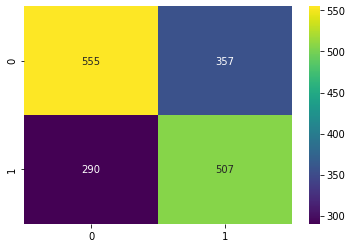

In [27]:
import seaborn as sns;

confusion = confusion_matrix(y_test, y_pred);

sns.heatmap(confusion, cmap='viridis', annot=True, fmt='d')

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.61      0.63       912
           1       0.59      0.64      0.61       797

   micro avg       0.62      0.62      0.62      1709
   macro avg       0.62      0.62      0.62      1709
weighted avg       0.62      0.62      0.62      1709

